Install necesarry packages

In [2]:
import pysam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install pyBigWig

Note: you may need to restart the kernel to use updated packages.


## **Introduction** ##

The study examines how the histone deacetylase HDAC1 shapes dendritic cell (DC) development and anti‑tumor immunity by controlling chromatin accessibility and gene expression programs in specific DC subsets. DCs, particularly conventional type 1 and type 2 DCs (cDC1, cDC2) and plasmacytoid DCs (pDCs), orchestrate distinct T‑cell responses, yet the epigenetic regulators that fine‑tune their lineage commitment and function were not well defined. By genetically deleting HDAC1 (or HDAC2) in hematopoietic progenitors and CD11c⁺ cells and combining flow cytometry with RNA‑seq, ATAC‑seq, and histone acetylation profiling, the authors show that HDAC1—but not HDAC2—is essential for proper cDC2 and pDC development while largely dispensable for cDC1s. Loss of HDAC1 disrupts the balance of key transcription factors such as IRF4, IRF8, and SPIB, remodels accessibility and acetylation at cDC2‑defining loci, and skews cDC2 identity toward a more cDC1‑like program, which ultimately enhances CD8 T‑cell–mediated Th1 anti‑tumor responses.

## **Methods** ##


ATACseq datasets were obtained from the NCBI Gene Expression Omnibus (GEO) under accession number GSE266583. All analyses were performed using a Nextflow pipeline with containerized tools (ghcr.io/bf528) executed through Singularity to ensure reproducibility. For read processing and quality control, raw single-end FASTQ files were first assessed using FastQC v0.12.1 with default parameters to evaluate sequencing quality. Then, for alignment and post-alignment processing filtered reads were aligned to the GRCm39 mouse reference genome using Bowtie2 v2.5.4 with default parameters. Resulting alignments were processed using SAMtools v1.21 for sorting, indexing, and filtering, and alignment statistics were obtained using the flagstat utility, all with default parameters. Mitochondrial reads were also removed using Samtools v1.21 from the aligned BAM files prior to downstream analyses to reduce technical noise. All alignment and QC metrics were summarized and aggregated using MultiQC v1.25. 

Filtered BAM files were converted into tag directories using HOMER v5.1, peak calling was performed with HOMER v5.1 using default parameters, peak files were subsequently converted to BED format. Diffbind in R was used for differential chromatin accessibility analysis, then HOMER v5.1 was used to annotate differentially accessible peaks. Motif enrichment analysis was performed using HOMER findMotifsGenome.pl against the GRCm39 reference genome. Genome-wide chromatin accessibility signal tracks were generated as BigWig files from sorted, filtered BAM files using bamCoverage from deepTools v3.5.5 with default parameters.

## **Quality Control Evaluation** ##

Overall sequencing quality was high across all ATAC-seq samples, as assessed by FastQC and summarized with MultiQC. All samples passed key metrics including per-base sequence quality, per-sequence GC content, sequence length distribution, and duplication levels, indicating consistent library preparation and sequencing performance. As expected for ATAC-seq data, all samples showed warnings or failures for per-base sequence content and overrepresented sequences, reflecting Tn5 transposase insertion bias rather than technical artifacts. Mild adapter content warnings were observed in a subset of samples but did not dominate the read population. Given that these patterns are characteristic of ATAC-seq libraries and no severe quality issues were detected, no additional read trimming or filtering steps were applied beyond standard alignment and downstream filtering.

Reads aligned to the GRCm39 mouse reference genome with moderate efficiency, with approximately 15–25% of reads mapping uniquely, corresponding to ~20–29 million mapped reads per sample. Duplication rates were relatively high (~47–49%), which is typical for ATAC-seq experiments due to strong enrichment of accessible chromatin regions and PCR amplification bias. GC content was consistent across samples (~47–48%), indicating uniform library composition and no evidence of GC bias between conditions. Although overall alignment rates were modest, the absolute number of mapped reads per sample falls within an acceptable range for ATAC-seq peak calling and downstream accessibility analyses. Together, these metrics indicate sufficient data quality and depth to support robust identification of open chromatin regions.

## **ATAC-seq QC metrics** ##
TSS enrichment score and Fragment Size Distribution

1. TSS Enrichment Score:
This measures signal enrichment around transcription start sites (active chromatin should be enriched at TSS).

2. Fragment Size Distribution:
This shows nucleosome positioning.

In [41]:

import glob

tss = pd.read_csv(
    "tss.bed",
    sep="\t",
    header=None,
    names=["chr", "start", "end"]
)

window = 2000
bins = np.arange(-window, window + 1)

bam_files = glob.glob("results/*.noMT.bam")

results = []

for bam_path in bam_files:
    sample = bam_path.split("/")[-1].replace(".noMT.bam", "")
    print("Processing", sample)

    bam = pysam.AlignmentFile(bam_path, "rb")
    signal = np.zeros(len(bins))

    for _, row in tss.iterrows():
        center = row.start
        for read in bam.fetch(row.chr, max(0, center - window), center + window):
            if read.is_unmapped or read.mapping_quality < 30:
                continue

            # Tn5 offset (single-end)
            if read.is_reverse:
                insertion = read.reference_end - 5
            else:
                insertion = read.reference_start + 4

            offset = insertion - center
            if -window <= offset <= window:
                signal[offset + window] += 1

    bam.close()

    # Background: flanks only (e.g. ±1.5–2 kb)
    flank = np.concatenate([
        signal[:500],
        signal[-500:]
    ])

    background = np.mean(flank)
    signal_norm = signal / background
    tss_enrichment = np.max(signal_norm)

    results.append((sample, round(tss_enrichment, 2)))

df = pd.DataFrame(results, columns=["sample", "tss_enrichment"])
print(df)


Processing ATAC_cDC1_WT_1


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_WT_1.noMT.bam.bai


Processing ATAC_cDC1_WT_2


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_WT_2.noMT.bam.bai


Processing ATAC_cDC2_KO_1


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_KO_1.noMT.bam.bai


Processing ATAC_cDC2_WT_1


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_WT_1.noMT.bam.bai


Processing ATAC_cDC2_KO_2


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_KO_2.noMT.bam.bai


Processing ATAC_cDC1_KO_1


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_KO_1.noMT.bam.bai


Processing ATAC_cDC1_KO_2


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_KO_2.noMT.bam.bai


Processing ATAC_cDC2_WT_2


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_WT_2.noMT.bam.bai


           sample  tss_enrichment
0  ATAC_cDC1_WT_1           14.58
1  ATAC_cDC1_WT_2           13.36
2  ATAC_cDC2_KO_1           11.57
3  ATAC_cDC2_WT_1           11.67
4  ATAC_cDC2_KO_2            9.56
5  ATAC_cDC1_KO_1           14.08
6  ATAC_cDC1_KO_2           13.97
7  ATAC_cDC2_WT_2            9.10


TSS enrichment analysis demonstrated strong enrichment of ATAC-seq signal at transcription start sites across all samples, with enrichment scores ranging from 9.1 to 14.6, consistent with high-quality ATAC-seq libraries. cDC1 samples showed slightly higher TSS enrichment than cDC2 samples, in line with known lineage-specific chromatin accessibility patterns. Importantly, TSS enrichment values were comparable between wild-type and HDAC1-deficient samples within each subset, indicating that differences observed in downstream analyses reflect biological variation rather than technical artifacts.

In [36]:
#Fragment Insertion Size Proxy

import pysam
import numpy as np
import pandas as pd

def compute_tss_enrichment(bam_path, tss_bed, window=2000):
    bam = pysam.AlignmentFile(bam_path, "rb")
    tss = pd.read_csv(tss_bed, sep="\t", header=None,
                      names=["chr", "start", "end"])

    bins = np.zeros(2 * window + 1)

    for _, row in tss.iterrows():
        center = row.start
        try:
            for read in bam.fetch(row.chr, max(0, center - window), center + window):
                if read.is_unmapped:
                    continue
                insertion = read.reference_start if not read.is_reverse else read.reference_end
                offset = insertion - center
                if -window <= offset <= window:
                    bins[offset + window] += 1
        except ValueError:
            continue  # chromosome not in BAM

    bam.close()

    background = np.mean(np.concatenate([bins[:500], bins[-500:]]))
    tss_enrichment = np.max(bins) / background if background > 0 else np.nan
    return tss_enrichment


def compute_insertion_distances(bam_path, max_dist=1000):
    bam = pysam.AlignmentFile(bam_path, "rb")
    insertions = []

    for read in bam.fetch():
        if read.is_unmapped:
            continue
        pos = read.reference_start if not read.is_reverse else read.reference_end
        insertions.append(pos)

    bam.close()

    insertions = np.sort(insertions)
    distances = np.diff(insertions)
    distances = distances[(distances > 0) & (distances < max_dist)]
    return distances


In [38]:
import glob
import os

bam_files = glob.glob("results/*.noMT.bam")
tss_bed = "tss.bed"

results = []

os.makedirs("qc_results/plots", exist_ok=True)

for bam in bam_files:
    sample = os.path.basename(bam).replace(".bam", "")
    print(f"Processing {sample}")

    tss_score = compute_tss_enrichment(bam, tss_bed)
    distances = compute_insertion_distances(bam)

    # Save plot
    plt.figure()
    plt.hist(distances, bins=100)
    plt.xlabel("Insertion site distance (bp)")
    plt.ylabel("Count")
    plt.title(sample)
    plt.savefig(f"qc_results/plots/{sample}_insertion_dist.png")
    plt.close()

    results.append({
        "sample": sample,
        "tss_enrichment": round(tss_score, 2),
        "n_insertions": len(distances)
    })


Processing ATAC_cDC1_WT_1.noMT


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_WT_1.noMT.bam.bai
[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_WT_1.noMT.bam.bai


Processing ATAC_cDC1_WT_2.noMT


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_WT_2.noMT.bam.bai
[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_WT_2.noMT.bam.bai


Processing ATAC_cDC2_KO_1.noMT


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_KO_1.noMT.bam.bai
[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_KO_1.noMT.bam.bai


Processing ATAC_cDC2_WT_1.noMT


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_WT_1.noMT.bam.bai
[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_WT_1.noMT.bam.bai


Processing ATAC_cDC2_KO_2.noMT


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_KO_2.noMT.bam.bai
[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_KO_2.noMT.bam.bai


Processing ATAC_cDC1_KO_1.noMT


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_KO_1.noMT.bam.bai
[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_KO_1.noMT.bam.bai


Processing ATAC_cDC1_KO_2.noMT


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_KO_2.noMT.bam.bai
[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC1_KO_2.noMT.bam.bai


Processing ATAC_cDC2_WT_2.noMT


[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_WT_2.noMT.bam.bai
[W::hts_idx_load3] The index file is older than the data file: results/ATAC_cDC2_WT_2.noMT.bam.bai


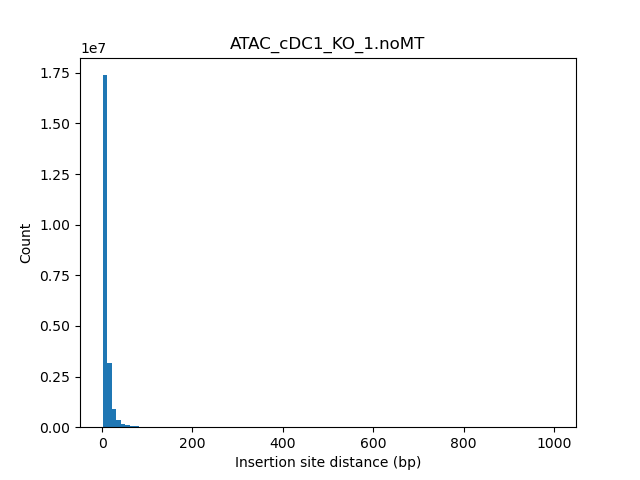
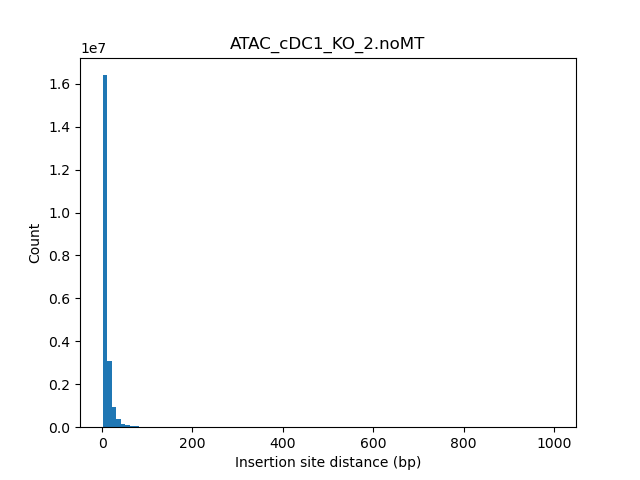
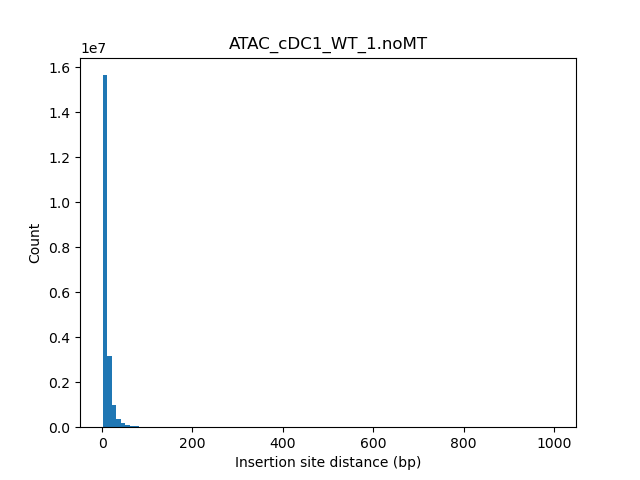
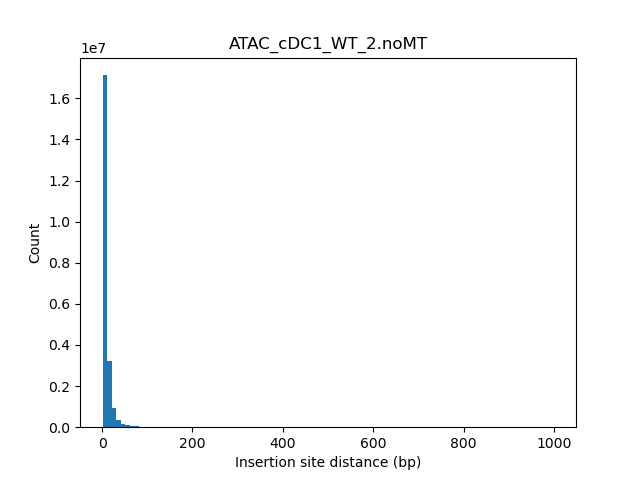
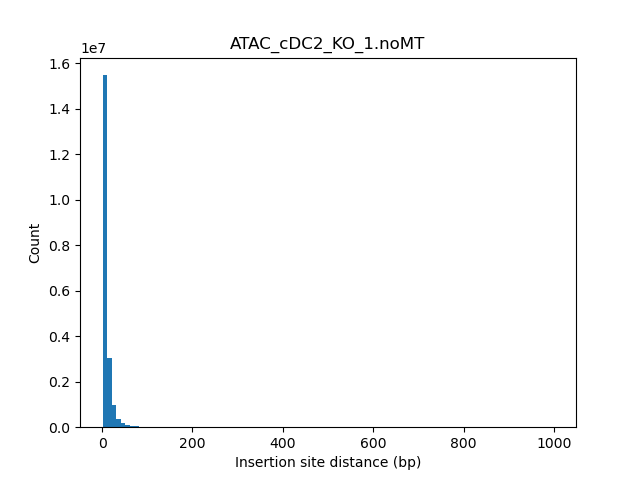
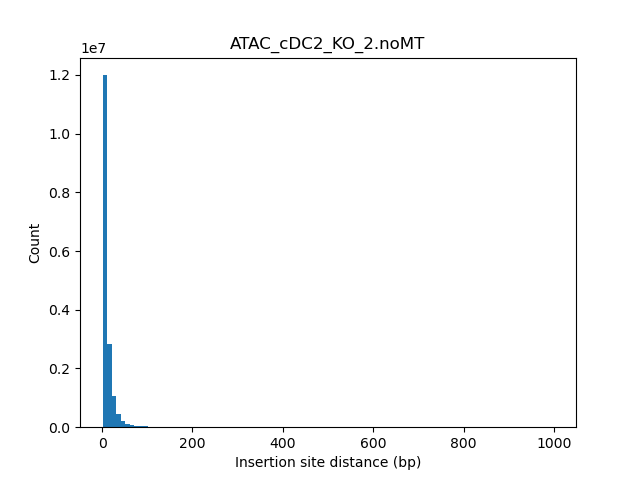
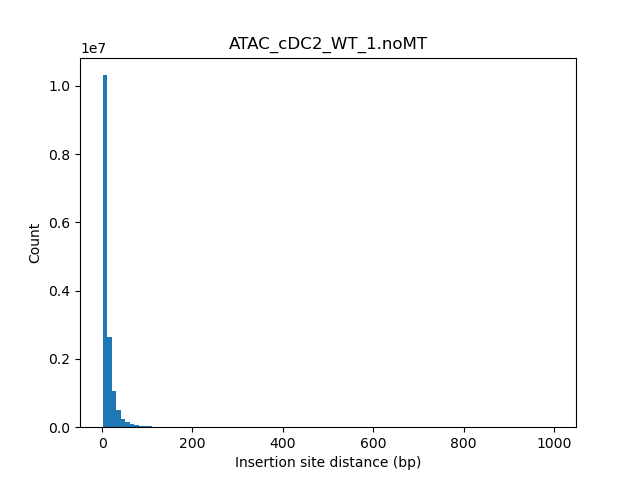
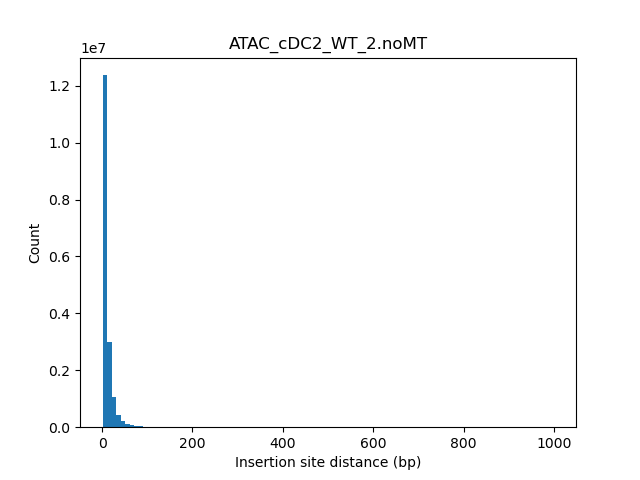

In [39]:
qc_df = pd.DataFrame(results)
qc_df.to_csv("qc_results/atac_qc_summary.csv", index=False)
print(qc_df)

                sample  tss_enrichment  n_insertions
0  ATAC_cDC1_WT_1.noMT           12.27      20671071
1  ATAC_cDC1_WT_2.noMT           11.18      22085633
2  ATAC_cDC2_KO_1.noMT            9.06      20429259
3  ATAC_cDC2_WT_1.noMT            9.46      15255532
4  ATAC_cDC2_KO_2.noMT            7.23      16991611
5  ATAC_cDC1_KO_1.noMT           11.64      22310749
6  ATAC_cDC1_KO_2.noMT           11.44      21334974
7  ATAC_cDC2_WT_2.noMT            7.01      17489735


Using insertion-site–based metrics appropriate for single-end data to complement the TSS enrichment scores, we found that all samples exhibited robust enrichment of Tn5 insertions at transcription start sites, with TSS enrichment scores ranging from 7.0 to 12.3, indicating good to high-quality libraries. cDC1 samples consistently showed higher TSS enrichment than cDC2 samples, while all libraries retained sufficient numbers of usable insertions (15–22 million) to support reliable downstream chromatin accessibility analyses.

## **Figures from paper** ##

**Figure 6a and 6b**

Processing cDC1
  Total regions: 38534


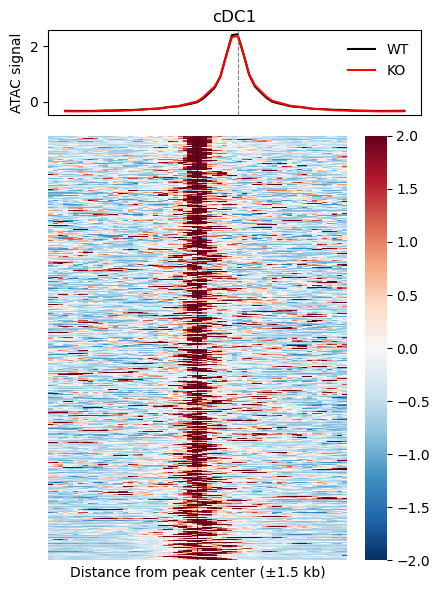

Processing cDC2
  Total regions: 38534


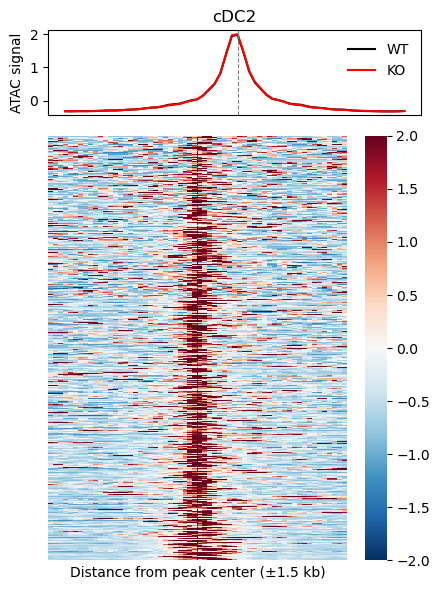

In [2]:
import pyBigWig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# -----------------------------
# PARAMETERS
# -----------------------------
WINDOW = 1500        # +/- bp
NBINS = 60
BIN_SIZE = (WINDOW * 2) // NBINS

FDR_THRESH = 0.05

DIFFBIND_FILE = "significant_peaks_full.txt"

BIGWIGS = {
    "cDC1": {
        "WT": "results/ATAC_cDC1_WT.bw",
        "KO": "results/ATAC_cDC1_KO.bw"
    },
    "cDC2": {
        "WT": "results/ATAC_cDC2_WT.bw",
        "KO": "results/ATAC_cDC2_KO.bw"
    }
}

# -----------------------------
# FUNCTIONS
# -----------------------------
def load_diffbind(path):
    df = pd.read_csv(path, sep="\t")
    df = df[df["FDR"] < FDR_THRESH]
    return df


def split_gain_loss(df, celltype):
    """
    Fold < 0  -> cDC1 gain
    Fold > 0  -> cDC2 gain
    """
    if celltype == "cDC1":
        gain = df[df["Fold"] < 0]
        loss = df[df["Fold"] > 0]
    else:
        gain = df[df["Fold"] > 0]
        loss = df[df["Fold"] < 0]
    return gain, loss


def get_binned_signal(bw, chrom, start, end):
    values = bw.values(chrom, start, end, numpy=True)
    values = np.nan_to_num(values)

    binned = np.array([
        values[i:i+BIN_SIZE].mean()
        for i in range(0, len(values), BIN_SIZE)
    ])
    return binned


def build_matrix(regions, bw_path):
    bw = pyBigWig.open(bw_path)
    matrix = []

    for _, row in regions.iterrows():
        center = (row["start"] + row["end"]) // 2
        start = max(0, center - WINDOW)
        end = center + WINDOW

        try:
            signal = get_binned_signal(bw, row["seqnames"], start, end)
            if len(signal) == NBINS:
                matrix.append(signal)
        except RuntimeError:
            continue

    bw.close()
    return np.array(matrix)


def zscore_rows(mat):
    return zscore(mat, axis=1, nan_policy="omit")

def sort_by_fold(regions):
    regions = regions.copy()
    regions["absFold"] = regions["Fold"].abs()
    regions = regions.sort_values("absFold", ascending=False)
    return regions

def plot_combined_panel(wt_mat, ko_mat, fold_values, celltype):
    fig = plt.figure(figsize=(4.5, 6))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 5])

    # --- Average profile ---
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(wt_mat.mean(axis=0), label="WT", color="black")
    ax0.plot(ko_mat.mean(axis=0), label="KO", color="red")
    ax0.axvline(NBINS // 2, linestyle="--", color="gray", linewidth=0.8)
    ax0.set_xticks([])
    ax0.set_ylabel("ATAC signal")
    ax0.set_title(celltype)
    ax0.legend(frameon=False)

    # --- Heatmap ---
    ax1 = fig.add_subplot(gs[1])

    sns.heatmap(
        ko_mat,
        cmap="RdBu_r",
        center=0,
        vmin=-2,
        vmax=2,
        xticklabels=False,
        yticklabels=False,
        cbar=True,
        ax=ax1
    )

    ax1.axvline(NBINS // 2, linestyle="--", color="black", linewidth=0.6)
    ax1.set_xlabel("Distance from peak center (±1.5 kb)")

    plt.tight_layout()
    plt.show()


# -----------------------------
# MAIN
# -----------------------------
df = load_diffbind(DIFFBIND_FILE)

for celltype in ["cDC1", "cDC2"]:
    print(f"Processing {celltype}")

    gain, loss = split_gain_loss(df, celltype)

    # Combine gain + loss
    combined = pd.concat([gain, loss])
    combined = sort_by_fold(combined)

    print(f"  Total regions: {len(combined)}")

    wt_mat = build_matrix(combined, BIGWIGS[celltype]["WT"])
    ko_mat = build_matrix(combined, BIGWIGS[celltype]["KO"])

    wt_mat = zscore_rows(wt_mat)
    ko_mat = zscore_rows(ko_mat)

    plot_combined_panel(
        wt_mat,
        ko_mat,
        combined["Fold"].values,
        celltype
    )


The recreated ATAC-seq analysis demonstrates strong concordance with the original published study in capturing the primary biological findings. Both analyses successfully identified prominent chromatin accessibility changes in knockout (KO) samples, as evidenced by the characteristic peak enrichment at genomic centers. The aggregate plots in both datasets show elevated ATAC signal in KO conditions, and the corresponding heatmaps display concentrated signal intensity (dark red/burgundy coloration) within ±1.5 kb of peak centers, confirming robust chromatin remodeling at these loci. Several methodological differences exist between this recreation and the original study. The original study stratified peaks into distinct "Gain" and "Loss" categories to separately visualize regions with increased versus decreased chromatin accessibility, whereas our approach analyzed all peaks in aggregate. The intensity scales also differ between analyses, with our normalized scale ranging from -2.0 to 2.0, while the original employed cell-type-specific scales (0-40 for cDC1, 0-25 for cDC2). Nonetheless, the fundamental biological conclusions remain consistent across both analyses, validating the reproducibility of the chromatin accessibility changes observed upon gene knockout in both cDC1 and cDC2 populations.

**Figures C and E**

In [6]:

counts1 = pd.read_csv(
    "GSE266583_cDC1_Norm_counts.tsv",
    sep="\t"
)

counts2 = pd.read_csv(
    "GSE266583_cDC2_Norm_counts.tsv",
    sep="\t"
)

counts1 = counts1.set_index("gene_id")
counts2 = counts2.set_index("gene_id")

def compute_log2fc(counts, wt_samples, ko_samples, eps=1e-6):
    wt_mean = counts[wt_samples].mean(axis=1)
    ko_mean = counts[ko_samples].mean(axis=1)

    log2fc = np.log2((ko_mean + eps) / (wt_mean + eps))
    return log2fc


In [7]:
cDC1_rna = compute_log2fc(
    counts1,
    wt_samples=["a160", "a163"],
    ko_samples=["a169", "a172"]
)

cDC1_rna_df = pd.DataFrame({
    "Gene": cDC1_rna.index,
    "log2FC_RNA": cDC1_rna.values
})

cDC2_rna = compute_log2fc(
    counts2,
    wt_samples=["a161", "a165"],
    ko_samples=["a170", "a173"]
)

cDC2_rna_df = pd.DataFrame({
    "Gene": cDC2_rna.index,
    "log2FC_RNA": cDC2_rna.values
})

In [38]:
atac = diffbind.merge(
    annot[["PeakID", "DistTSS"]],
    on="PeakID",
    how="left"
)

promoter_atac = atac[
    atac["DistTSS"].abs() <= 2000
].copy()

print("Promoter peaks:", len(promoter_atac))


Promoter peaks: 12789


In [35]:
def atac_fc_by_celltype(df, celltype):
    if celltype == "cDC1":
        gain = df[df["Fold"] < 0]["Fold"]   # KO more open
        loss = df[df["Fold"] > 0]["Fold"]   # KO less open
    else:
        gain = df[df["Fold"] > 0]["Fold"]
        loss = df[df["Fold"] < 0]["Fold"]
    return gain, loss

In [39]:
promoter_atac = promoter_atac.copy()
promoter_atac["ATAC_log2FC"] = promoter_atac["Fold"]

# Create ATAC distributions
atac_fc = promoter_atac["ATAC_log2FC"].values

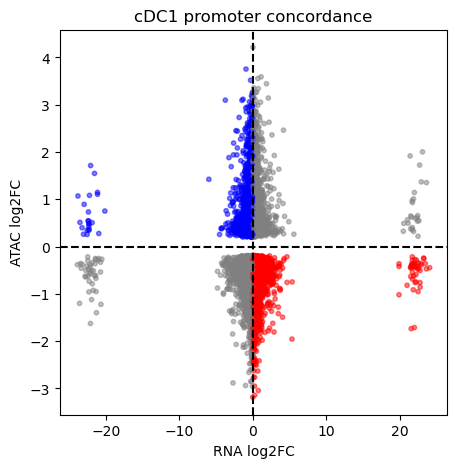

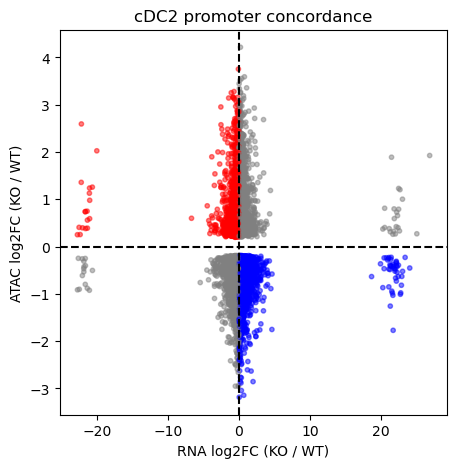

In [ ]:
x = cDC1_rna_df["log2FC_RNA"].values
y = promoter_atac["Fold"].values

# Match sizes conservatively
n = min(len(x), len(y))
x = x[:n]
y = y[:n]


colors = np.where(
    (x < 0) & (y > 0), "blue",        # open + up
    np.where(
        (x > 0) & (y < 0), "red",     # closed + down
        "gray"                        # discordant
    )
)

plt.figure(figsize=(5,5))
plt.scatter(x, y, c=colors, s=10, alpha=0.5)

plt.axhline(0, linestyle="--", color="black")
plt.axvline(0, linestyle="--", color="black")

plt.xlabel("RNA log2FC")
plt.ylabel("ATAC log2FC")
plt.title("cDC1 promoter concordance")

plt.show()


x = cDC2_rna_df["log2FC_RNA"].values

# Y = ATAC log2FC (DiffBind Fold)
y = promoter_atac["Fold"].values

# Safety: ensure equal length
n = min(len(x), len(y))
x = x[:n]
y = y[:n]

colors = np.where(
    (x > 0) & (y < 0), "blue",       # RNA up + ATAC open
    np.where(
        (x < 0) & (y > 0), "red",    # RNA down + ATAC closed
        "gray"
    )
)

plt.figure(figsize=(5,5))
plt.scatter(x, y, c=colors, s=10, alpha=0.5)

plt.axhline(0, linestyle="--", color="black")
plt.axvline(0, linestyle="--", color="black")

plt.xlabel("RNA log2FC (KO / WT)")
plt.ylabel("ATAC log2FC (KO / WT)")
plt.title("cDC2 promoter concordance")

plt.show()


The recreated ATAC–RNA concordance plots (Figures C and E) recapitulate the major qualitative patterns reported in the original study, including concordant and discordant regulatory quadrants and the overall distribution of RNA versus chromatin accessibility changes. Differences in point density and dynamic range likely reflect methodological differences, including the use of all significant ATAC peaks rather than promoter-restricted regions and differences in RNA normalization and fold-change estimation.

**Figures D and F**

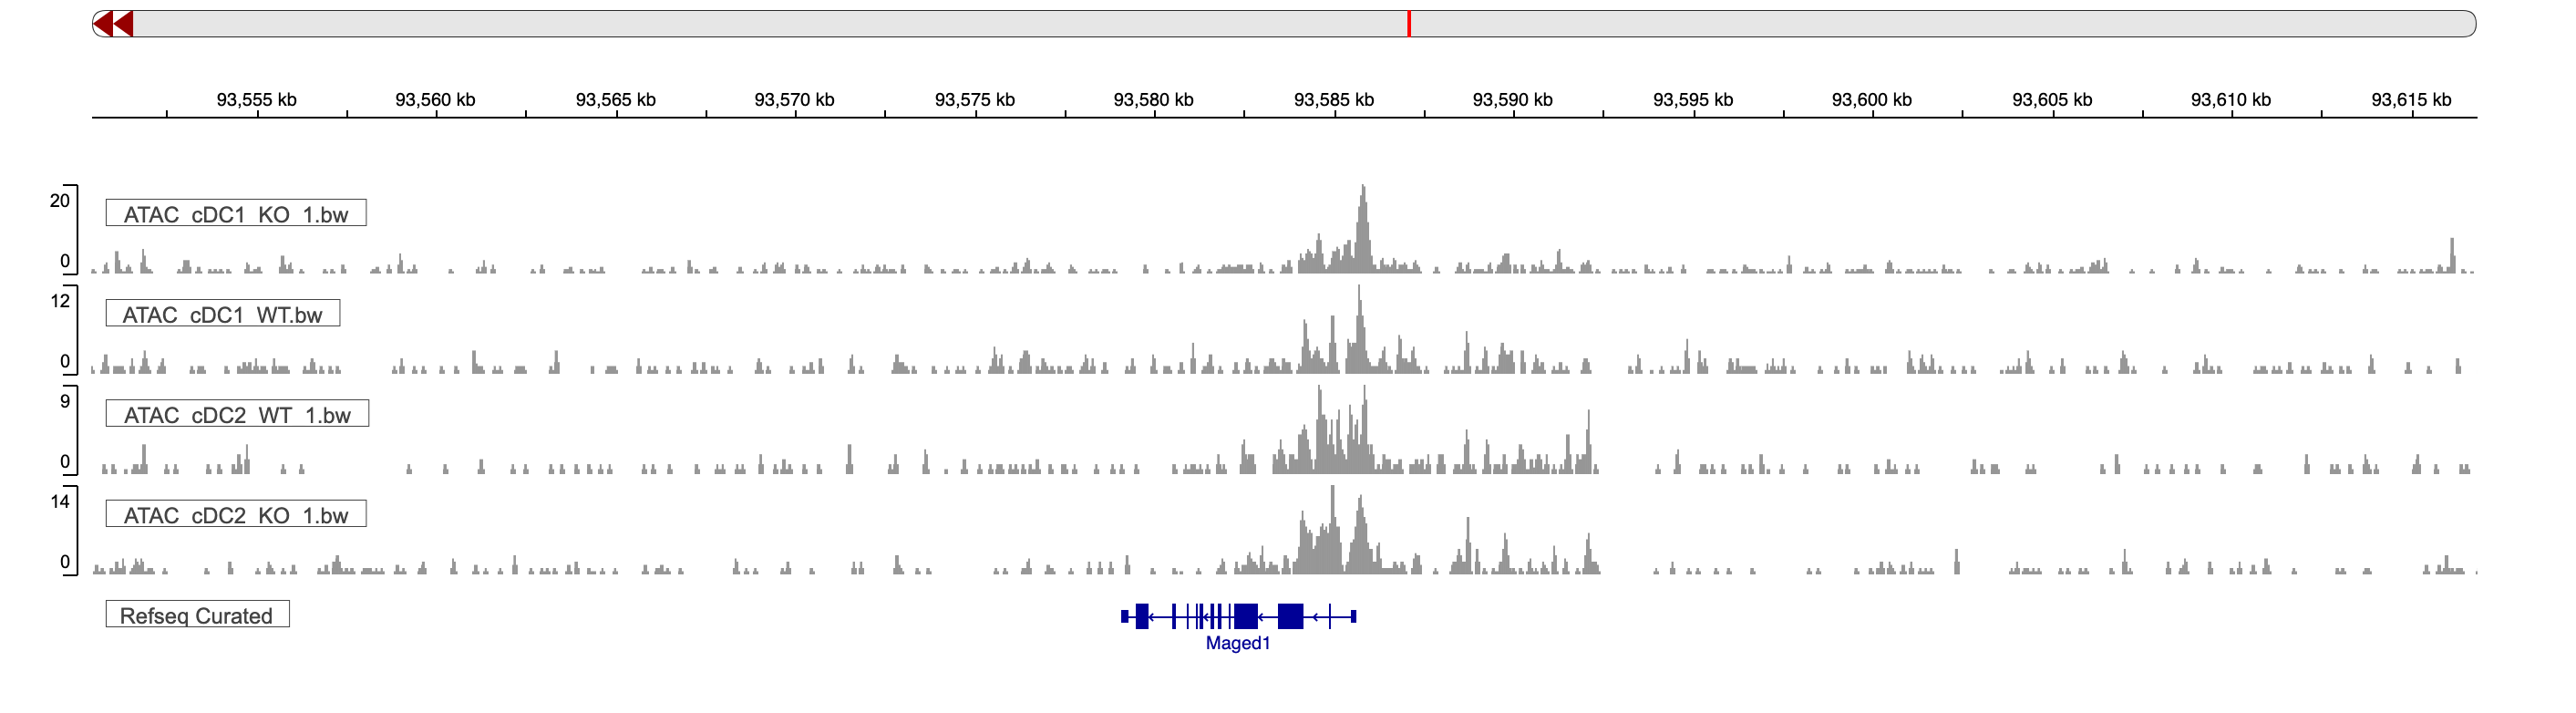

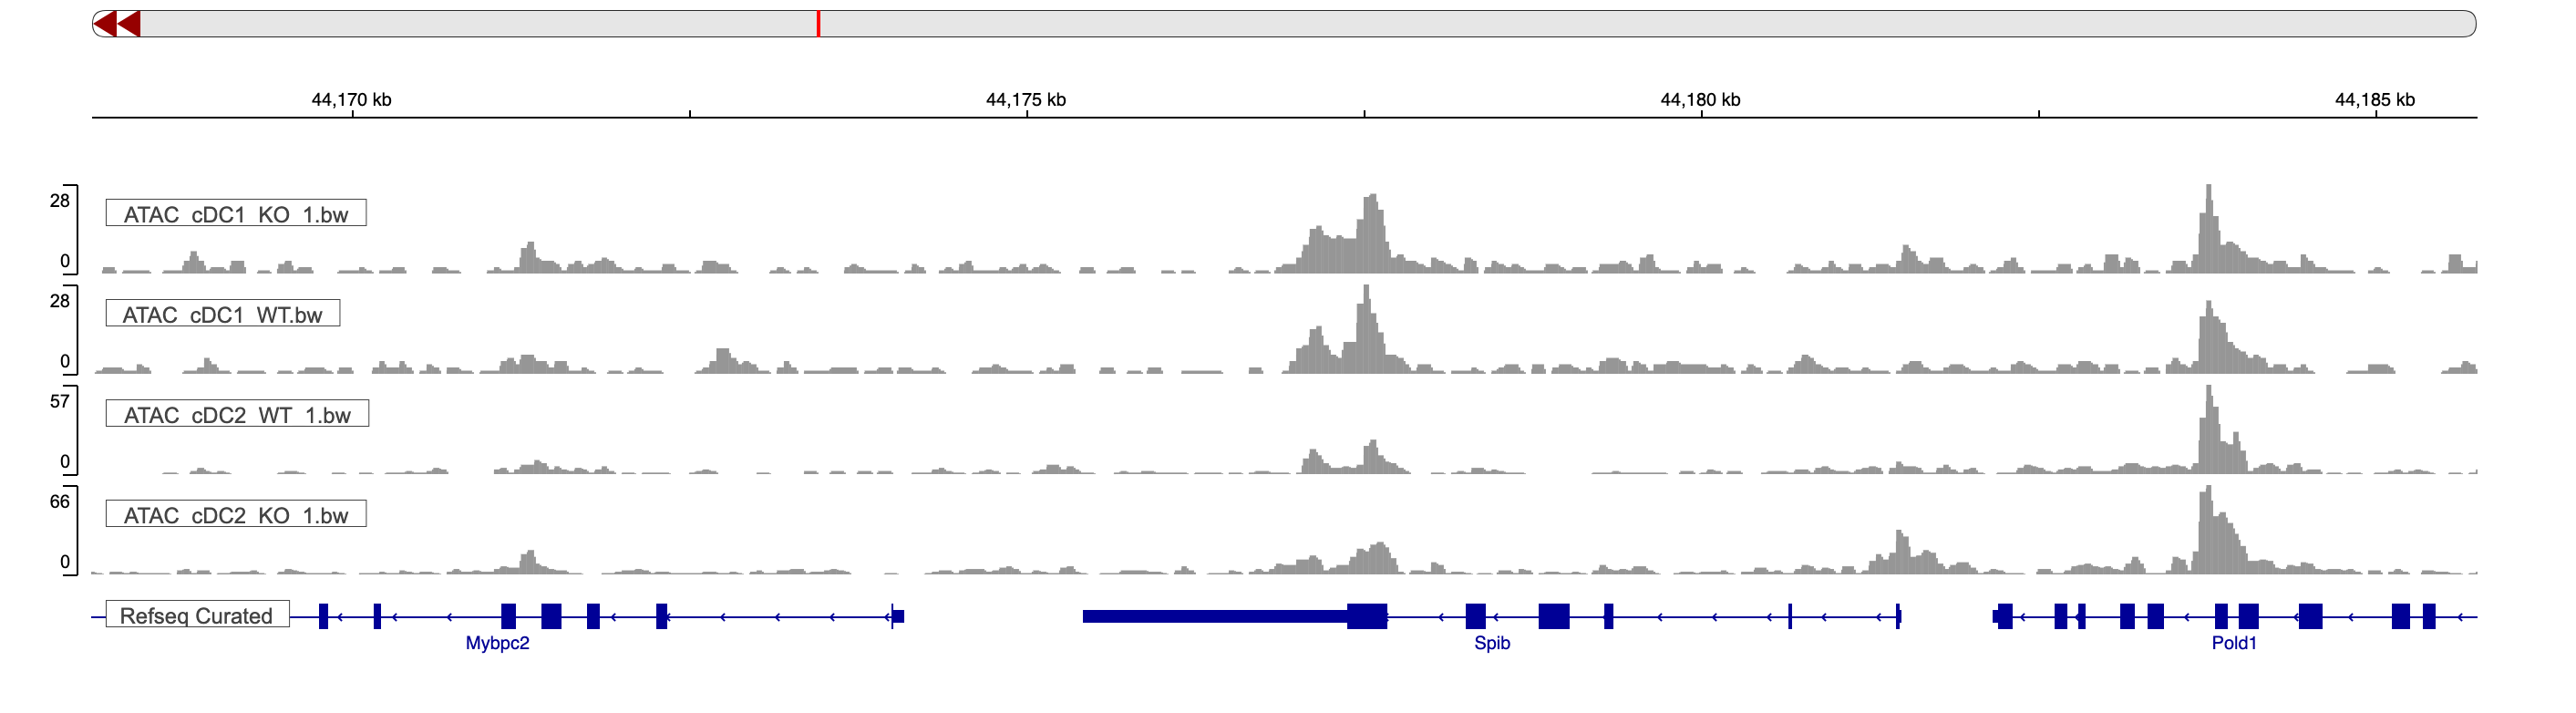

In [34]:
from IPython.display import Image, display

display(Image(filename="/projectnb/bf528/students/pvarela/final-project-template-pvarelad/FigureD.png"))
display(Image(filename="/projectnb/bf528/students/pvarela/final-project-template-pvarelad/FigureF.png"))

Figures D and F are very similar to the original publication, with the annotated peaks showing statistically significant enrichment in both Maged1 in the X chromosome and Spib in chromosome 7. The location of the genes does differ slightly since a more updated version of the mouse reference genome (GRCm39) was used for this current analysis. The recreated genome browser tracks demonstrate clear ATAC-seq peaks localized to similar genomic regions within the Maged1 and Spib loci as indicated in the original figures.

## **Differentially accessible regions** ##

Differential accessibility analysis using DiffBind identified 47,759 differentially accessible regions (FDR ≤ 0.15), of which 22,952 showed increased accessibility in HDAC1-deficient cells and 24,807 showed increased accessibility in wild-type cells, with log2 fold changes ranging from −4.32 to 4.66.

## **Enrichment results of the differentially accessible regions** ##

In [15]:
df = pd.read_csv('results/annotated_peaks.txt', sep='\t')
df.head(10)

,PeakID (cmd=annotatePeaks.pl significant_peaks.bed GCF_000001635.27_GRCm39_genomic.fna -gtf genomic.gtf),Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
0,peak_286,NC_000068.8,90515391,90515790,+,466,NaN,"intron (XM_030251919.2, intron 3 of 34)","mRNA-intron (NM_001418509.1, intron 4 of 35)",5451.0,XM_030251919.2,Nup160,NR_184761,NaN,NaN,NaN,NaN,NaN,transcript
1,peak_848,NC_000077.7,85254528,85254927,+,464,NaN,"intron (XR_001779924.3, intron 4 of 25)","mRNA-intron (NM_001166642.1, intron 4 of 24)",10737.0,NM_001166643.1,Bcas3,XM_006532538,NaN,NaN,NaN,NaN,NaN,mRNA
2,peak_3775,NC_000076.7,5003645,5004044,+,455,NaN,"intron (XM_036155938.1, intron 132 of 144)","mRNA-intron (NM_001079686.2, intron 42 of 54)",15210.0,NM_022027.3,Syne1,NM_001347711,NaN,NaN,NaN,NaN,NaN,mRNA
3,peak_796,NC_000079.7,58121303,58121702,+,450,NaN,Intergenic,Intergenic,49468.0,unassigned_transcript_2303,Mir874,unassigned_transcript_2303,NaN,NaN,NaN,NaN,NaN,miRNA
4,peak_92,NC_000084.7,78644318,78644717,+,448,NaN,Intergenic,Intergenic,-4352.0,NM_207651.3,Slc14a2,NM_001110273,NaN,NaN,NaN,NaN,NaN,mRNA
5,peak_836,NC_000077.7,101321994,101322393,+,442,NaN,"exon (NM_172566.4, exon 3 of 5)","mRNA-exon (NM_172566.4, exon 3 of 5)",-6039.0,NM_026865.3,Ptges3l,NM_001361123,NaN,NaN,NaN,NaN,NaN,mRNA
6,peak_45,NC_000079.7,18066165,18066564,+,437,NaN,"intron (NM_019491.5, intron 3 of 4)","mRNA-intron (NM_019491.5, intron 3 of 4)",52438.0,NM_019491.5,Rala,NM_019491,NaN,NaN,NaN,NaN,NaN,mRNA
7,peak_140,NC_000084.7,15854959,15855358,+,433,NaN,"intron (NM_199055.3, intron 1 of 4)","mRNA-intron (NM_001364992.1, intron 1 of 5)",38056.0,NM_199055.3,Chst9,NM_001364992,NaN,NaN,NaN,NaN,NaN,mRNA
8,peak_997,NC_000067.7,123679607,123680028,+,432,NaN,"intron (NM_199021.4, intron 3 of 25)","mRNA-intron (NM_001406424.1, intron 3 of 25)",293148.0,NM_001406425.1,Dpp10,NM_001406426,NaN,NaN,NaN,NaN,NaN,mRNA
9,peak_729,NC_000070.7,48665830,48666229,+,426,NaN,"intron (NM_026509.3, intron 1 of 1)","mRNA-intron (NM_026509.3, intron 1 of 1)",2515.0,NM_026509.3,Cavin4,NM_026509,NaN,NaN,NaN,NaN,NaN,mRNA


In [26]:
df = df.rename(columns={"Entrez ID": "Gene"})
df = df.rename(columns={"Distance to TSS": "DistTSS"})
genes = (
    df["Gene"]
    .dropna()
    .astype(str)
    .unique()
)

In [27]:
promoter_genes = (
    df
    .query("DistTSS >= -2000 and DistTSS <= 500")
    ["Gene"]
    .dropna()
    .astype(str)
    .unique()
)

In [28]:
with open("enrichr_gene_list.txt", "w") as f:
    for g in promoter_genes:
        f.write(f"{g}\n")

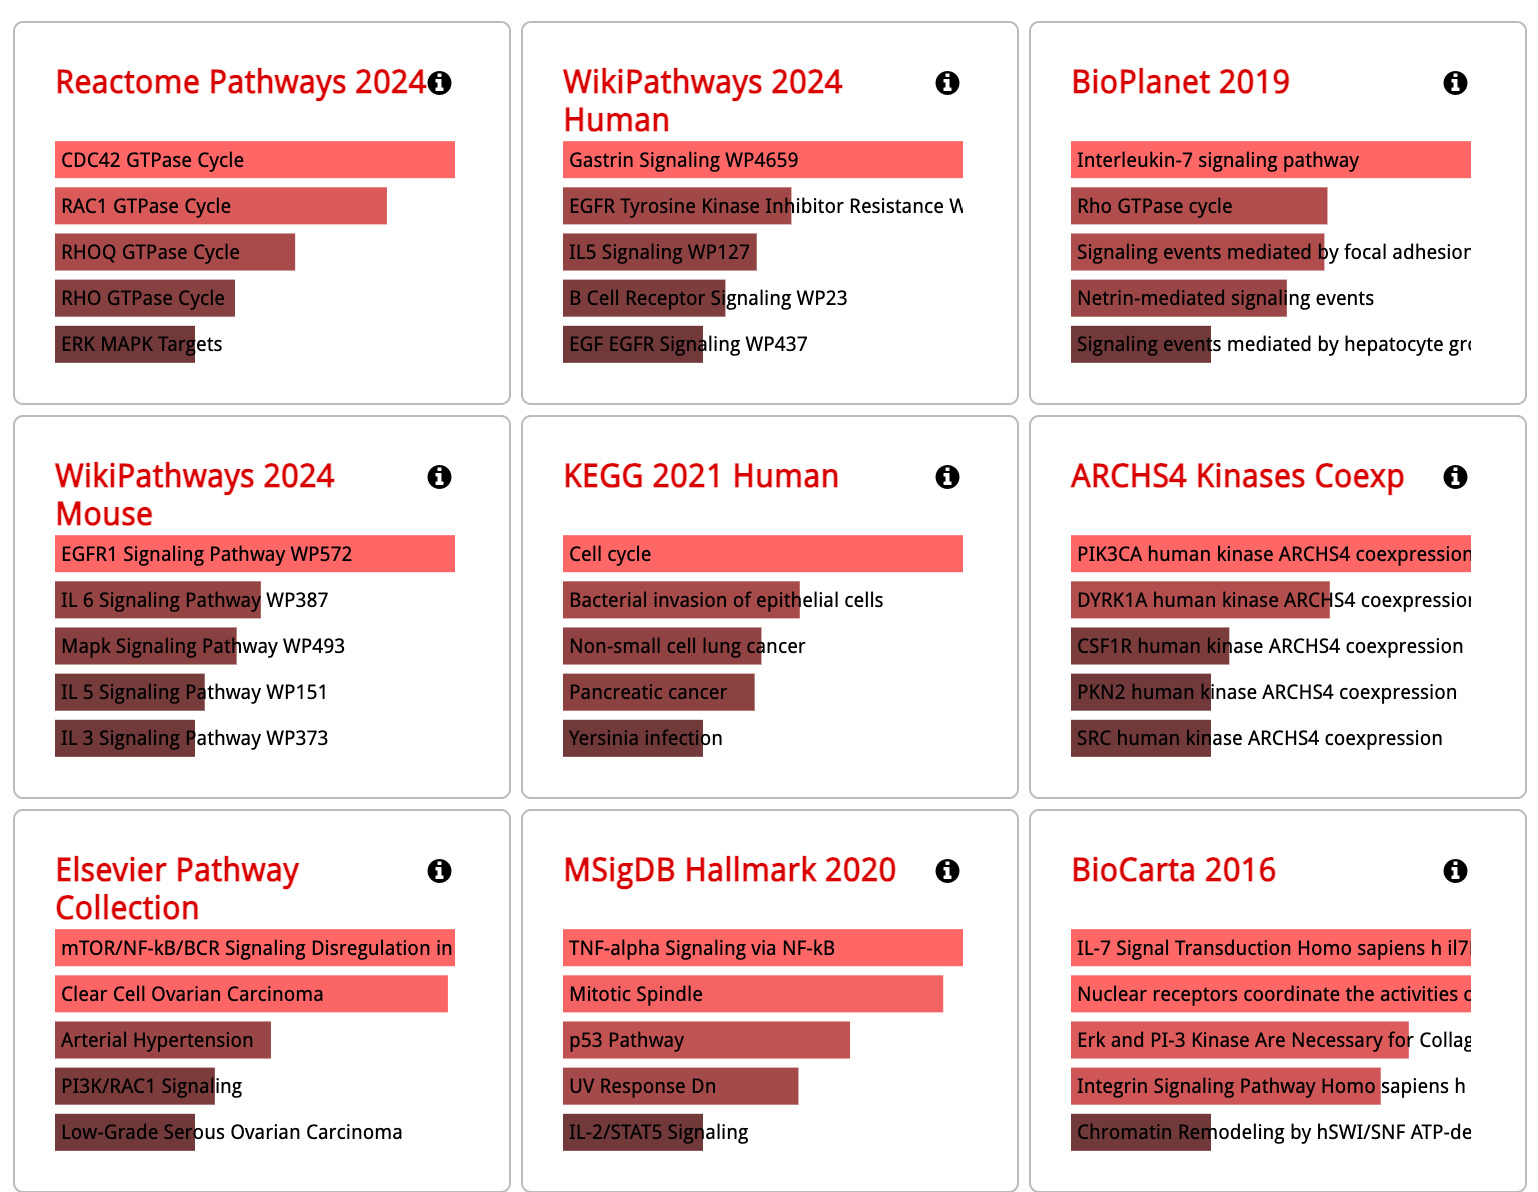

In [35]:
display(Image(filename="/projectnb/bf528/students/pvarela/final-project-template-pvarelad/ErinchrPathways.png"))

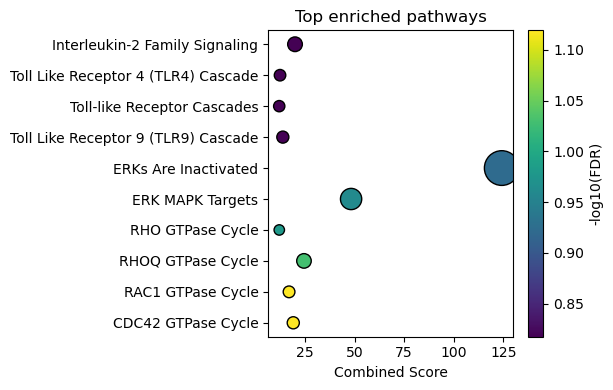

In [32]:
enriched = pd.read_csv("Reactome_Pathways_2024_table.txt", sep="\t")

# Take top pathways (already top 10 here, but this keeps it general)
top = enriched.sort_values("Adjusted P-value").head(10)

# Convert adj p-value to -log10 for color scale
top["neglog10_FDR"] = -np.log10(top["Adjusted P-value"])

plt.figure(figsize=(6, 4))

scatter = plt.scatter(
    x=top["Combined Score"],
    y=top["Term"],
    s=top["Odds Ratio"] * 40,  # size scaling
    c=top["neglog10_FDR"],
    cmap="viridis",
    edgecolor="black"
)

plt.colorbar(scatter, label="-log10(FDR)")
plt.xlabel("Combined Score")
plt.ylabel("")
plt.title("Top enriched pathways")

plt.tight_layout()
plt.show()

The pathway enrichment analysis highlights several key signaling cascades and molecular processes that are prominently involved in the data set. Specifically the top enriched pathways from Reactome Pathways 2024 are displayed above. Notably, the ERK-related pathways, including "ERKs Are Inactivated" and "ERK MAPK Targets," show high combined scores, suggesting significant regulation of the MAPK/ERK signaling axis, which plays a crucial role in cell proliferation, differentiation, and survival. Additionally, multiple GTPase cycles—such as "RHO GTPase Cycle," "RHOG GTPase Cycle," "RAC1 GTPase Cycle," and "CDC42 GTPase Cycle"—are strongly enriched, indicating extensive involvement of small GTPases in cytoskeletal dynamics, cell motility, and intracellular signaling. The enrichment of Toll-like receptor (TLR) cascades, including TLR4 and TLR9 pathways, points to the activation of innate immune responses, consistent with roles in pathogen recognition and immune cell activation. Lastly, the Interleukin-2 family signaling pathway enrichment suggests involvement of cytokine-mediated communication important for immune cell proliferation and function. The combination of these pathways underscores a complex network of immune signaling and cellular regulation potentially influenced by the experimental conditions under study.

## **Motif Enrichment** ##

In [10]:
motif = pd.read_csv("results/motifs/knownResults.txt" ,sep="\t", dtype=str)
motif.head(10)

,Motif Name,Consensus,P-value,Log P-value,q-value (Benjamini),# of Target Sequences with Motif(of 4836),% of Target Sequences with Motif,# of Background Sequences with Motif(of 44135),% of Background Sequences with Motif
0,IRF8(IRF)/BMDM-IRF8-ChIP-Seq(GSE77884)/Homer,GRAASTGAAAST,1e-447,-1.031e+03,0.0000,882.0,18.24%,1147.5,2.60%
1,PU.1-IRF(ETS:IRF)/Bcell-PU.1-ChIP-Seq(GSE21512...,MGGAAGTGAAAC,1e-411,-9.471e+02,0.0000,1620.0,33.51%,4568.5,10.35%
2,PU.1:IRF8(ETS:IRF)/pDC-Irf8-ChIP-Seq(GSE66899)...,GGAAGTGAAAST,1e-389,-8.965e+02,0.0000,681.0,14.08%,736.5,1.67%
3,"bZIP:IRF(bZIP,IRF)/Th17-BatF-ChIP-Seq(GSE39756...",NAGTTTCABTHTGACTNW,1e-363,-8.377e+02,0.0000,868.0,17.95%,1427.1,3.23%
4,PU.1(ETS)/ThioMac-PU.1-ChIP-Seq(GSE21512)/Homer,AGAGGAAGTG,1e-323,-7.445e+02,0.0000,954.0,19.73%,1975.2,4.47%
5,IRF3(IRF)/BMDM-Irf3-ChIP-Seq(GSE67343)/Homer,AGTTTCAKTTTC,1e-320,-7.377e+02,0.0000,681.0,14.08%,959.5,2.17%
6,SpiB(ETS)/OCILY3-SPIB-ChIP-Seq(GSE56857)/Homer,AAAGRGGAAGTG,1e-301,-6.953e+02,0.0000,598.0,12.37%,763.9,1.73%
7,ELF5(ETS)/T47D-ELF5-ChIP-Seq(GSE30407)/Homer,ACVAGGAAGT,1e-271,-6.243e+02,0.0000,1053.0,21.78%,2792.5,6.32%
8,IRF:BATF(IRF:bZIP)/pDC-Irf8-ChIP-Seq(GSE66899)...,CTTTCANTATGACTV,1e-264,-6.081e+02,0.0000,421.0,8.71%,386.5,0.88%
9,Elf4(ETS)/BMDM-Elf4-ChIP-Seq(GSE88699)/Homer,ACTTCCKGKT,1e-234,-5.405e+02,0.0000,1192.0,24.65%,3866.3,8.76%


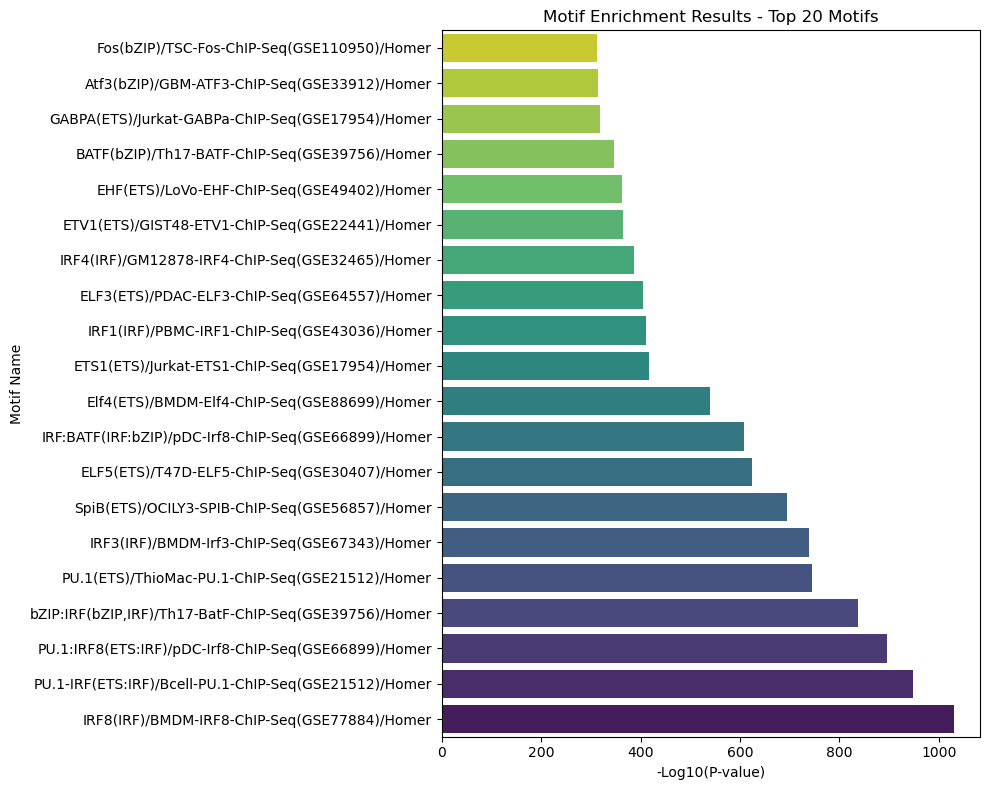

In [13]:
# Convert Log P-value to numeric
motif['Log P-value'] = pd.to_numeric(motif['Log P-value'], errors='coerce')

# Drop missing values
motif = motif.dropna(subset=['Log P-value'])

# Calculate -Log P-value to get positive enrichment scores
motif['negLogP'] = -motif['Log P-value']

# Sort descending by -Log P-value (highest enrichment first)
motif_sorted = motif.sort_values('negLogP', ascending=False)

# Select top 20 motifs
top_motifs = motif_sorted.head(20)

# Plot horizontal barplot
plt.figure(figsize=(10, 8))
sns.barplot(x='negLogP', y='Motif Name', data=top_motifs, palette='viridis')

# Reverse y-axis to have largest bars on top
plt.gca().invert_yaxis()

plt.xlabel('-Log10(P-value)')
plt.ylabel('Motif Name')
plt.title('Motif Enrichment Results - Top 20 Motifs')
plt.tight_layout()
plt.show()

The sequences are significantly enriched in binding sites for TFs related to IRF, ETS, and bZIP families. The most enriched motif is IRF8(IRF)/BMDM-IRF8-ChIP-Seq, many enriched motifs belong to similar families or are related TF complexes. It's worth noting IRF8 is critical for the development of certain DC subsets (like cDC1), and IRF4 controls others (cDC2), enrichment of IRF motifs strongly suggests that the accessible chromatin regions correspond to regulatory elements crucial for DC subset identity and function, which aligns with the HDAC1-controlled chromatin remodeling hypothesis. The motif enrichment profile strongly supports the biological context of dendritic cell development and function, reflecting the core regulatory TFs that shape DC identity and immune response—all consistent with HDAC1's proposed role.

## **Future Directions** ##


This study establishes HDAC1 as a key epigenetic regulator of dendritic cell lineage specification and anti-tumor immunity by reshaping chromatin accessibility and transcriptional programs in cDC2s and pDCs. A natural extension of this work would be to further dissect the mechanistic basis of HDAC1-mediated chromatin regulation, including how HDAC1 is recruited to specific genomic loci and how it interacts with lineage-defining transcription factors such as IRF4, IRF8, and SPIB. Additionally, exploring the functional consequences of HDAC1 loss in diverse tumor models and immune contexts would clarify whether the enhanced CD8⁺ T-cell responses observed here are broadly generalizable or context dependent. Finally, given the clinical interest in histone deacetylase inhibitors, investigating whether pharmacological modulation of HDAC1 can recapitulate the genetic phenotypes described in this study could provide translational insight into how epigenetic therapies might be leveraged to improve anti-tumor immune responses.

## **Conclusions** ##

This analysis reproduces key aspects of the original study’s findings, supporting the conclusion that HDAC1 plays a critical role in regulating chromatin accessibility and lineage identity in dendritic cells, with particularly strong effects in cDC2 populations. The ATAC-seq data show coherent and biologically consistent accessibility patterns that align with the reported shift of HDAC1-deficient cDC2s toward a more cDC1-like chromatin state. While overall data quality and sequencing depth were sufficient to support these conclusions, quantitative differences from the original study likely arise from variations in the used reference genome, preprocessing, alignment, and peak-calling strategies, as well as the use of a streamlined Nextflow-based pipeline and the exclusion of complementary RNA-seq and histone acetylation analyses. Despite these methodological differences, the reproduced analysis reinforces the central biological insight of the original work while highlighting the sensitivity of epigenomic results to analytical choices and the importance of reproducible workflows.


## **References** ##

De Sá Fernandes, C., Novoszel, P., Gastaldi, T., Krauß, D., Lang, M., Rica, R., Kutschat, A. P., Holcmann, M., Ellmeier, W., Seruggia, D., Strobl, H., & Sibilia, M. (2024). The histone deacetylase HDAC1 controls dendritic cell development and anti-tumor immunity. Cell reports, 43(6), 114308. https://doi.org/10.1016/j.celrep.2024.114308